In [3]:
using Pkg
Pkg.activate(".")

  Activating new project at `/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/mESC`


In [32]:
using locaTE
using OptimalTransport
using NPZ
using StatsBase
using SparseArrays
using ProgressMeter
using Plots
using NearestNeighbors
using Graphs
using GraphSignals
using Printf
using Base.Threads
using LinearAlgebra
using DataFrames
using CSV
using Distances
using NNlib
using Discretizers
using EvalMetrics
using Random
using LaTeXStrings
# discretization length for AUPRC
Nq = 500
# plot sizes
PLT_CELL = 500
# figure directory
FIG_DIR = "."
# 
DATA_PATH="../../data/mESC/"

"../../data/mESC/"

In [33]:
# load logarithmized counts
X = npzread(string(DATA_PATH, "X.npy"))
X = relu.(X .- 1e-2);
# gene names
try
    global genes = Array(CSV.read(string(DATA_PATH, "genes.txt"), DataFrame)[:, 2])
catch e
    @info "Exception: $e"
    global genes = ["gene_$i" for i = 1:size(X, 2)];
end
# PCA coords, etc.
X_pca = npzread(string(DATA_PATH, "X_pca.npy"))
P = npzread(string(DATA_PATH, "P_statot.npy"))
C = npzread(string(DATA_PATH, "C.npy"))
dpt = npzread(string(DATA_PATH, "dpt.npy"));
# reference dataset
J = npzread(string(DATA_PATH, "J.npy"));
J[diagind(J)] .= 0;
J_escape = npzread(string(DATA_PATH,"J_ESCAPE.npy"));
J_escape[diagind(J_escape)] .= 0;

In [34]:
# neighbourhood kernel
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5*mean(C));
# gene indices
gene_idxs = vcat([[j, i]' for i = 1:size(X, 2) for j = 1:size(X, 2)]...);
# transition matrices
k = 1
π_unif = fill(1/size(P, 1), size(P, 1))'
Q = (P' .* π_unif)./(π_unif * P)';
P_sp = sparse((P^k))
QT_sp = sparse((Q^k)')
R_sp = sparse(R);

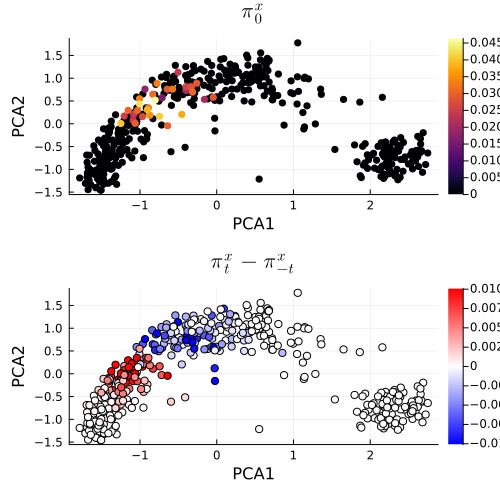

In [35]:
# visualise 
p0 = R[sortperm(dpt)[250], :]
plt=plot(scatter(X_pca[sortperm(p0), 1], X_pca[sortperm(p0), 2]; marker_z = sort(p0), markerstrokewidth = 0, alpha = 1.0, xlabel = "PCA1", ylabel = "PCA2", title = L"π_0^x"), 
    scatter(X_pca[:, 1], X_pca[:, 2]; marker_z = P_sp'*p0 - QT_sp*p0, color = :bwr, clim = (-0.0101, 0.0101), alpha = 1.0, xlabel = "PCA1", ylabel = "PCA2", title = L"\pi^x_{t} - \pi^x_{-t}"); legend = nothing, layout = (2, 1), size = (PLT_CELL, PLT_CELL))
savefig(string(FIG_DIR, "mESC_pca_densities.pdf"))
plt

In [39]:
# construct kNN and Laplacian
kdtree = KDTree(X_pca')
idxs, dists = knn(kdtree, X_pca', 25);
A = spzeros(size(X_pca, 1), size(X_pca, 1));
for (i, j) in enumerate(idxs)
    A[i, j] .= 1.0
end
L = sparse(normalized_laplacian(max.(A, A'), Float64));

In [40]:
# setup discretization
alg = DiscretizeBayesianBlocks()
disc = locaTE.discretizations_bulk(X; alg = alg);
# directed inference using GPU
using CUDA
disc_max_size = maximum(map(x -> length(x[1])-1, disc))
N_blocks = 1
joint_cache = get_joint_cache(size(X, 2) ÷ N_blocks, disc_max_size);
ids_cu = hcat(map(x -> x[2], disc) ...) |> cu;
# copy transition and neighborhood kernels to GPU
P_cu = cu(Array(P_sp))
QT_cu = cu(Array(QT_sp))
R_cu = cu(Array(R_sp));
# compute TE scores
mi_all_gpu = zeros(Float32, size(X, 1), size(X, 2), size(X, 2)) |> cu
p = Progress(size(X, 1));
for i = 1:size(X, 1)
    gamma, idx0, idx1 = locaTE.getcoupling_dense_trimmed(i, P_cu, QT_cu, R_cu) 
    for ((N_x, N_y), (offset_x, offset_y)) in locaTE.getblocks(size(X, 2), N_blocks, N_blocks)
        get_MI!(view(mi_all_gpu, i, :, :), joint_cache, gamma, size(X, 2), ids_cu[idx0, :], ids_cu[idx1, :]; offset_x = offset_x, N_x = N_x, offset_y = offset_y, N_y = N_y)
    end
    next!(p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [42]:
mi_all = reshape(mi_all_gpu, size(X, 1), size(X, 2)^2) |> Array;
@info "Applying CLR"
mi_all_clr = apply_wclr(mi_all, size(X, 2))
mi_all_clr[isnan.(mi_all_clr)] .= 0
@info "Denoising"
G = fitsp(cu(mi_all_clr), cu(Array(L)); λ1 = 10.0, λ2 = 0.001, maxiter = 500) |> Array;

[ Info: Applying CLR
[ Info: Denoising
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
[ Info: ΔX = 4.660340027680545e-8, ΔZ = 7.996027011614865e-6, ΔW = 9.980232406121836e-6
[ Info: tr(X'LX) = 2.578960035914981, 0.5|X-G|^2 = 6.0102876904346765, |X|1 = 6600.929833255421


In [43]:
agg_fun = x -> mean(x[dpt .< quantile(dpt, 0.9), :]; dims = 1)

#29 (generic function with 1 method)

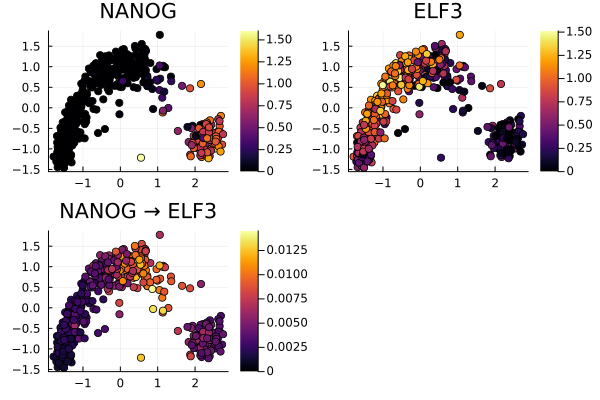

In [45]:
# g1 = "POU5F1"
g1 = "NANOG"
g2 = "ELF3"
plot(scatter(X_pca[:, 1], X_pca[:, 2], marker_z = X[:, findfirst(x -> x == g1, genes)], title = g1), 
    scatter(X_pca[:, 1], X_pca[:, 2], marker_z = X[:, findfirst(x -> x == g2, genes)], title = g2), 
    scatter(X_pca[:, 1], X_pca[:, 2], marker_z = reshape(G, :, size(X, 2), size(X, 2))[:, findfirst(x -> x == g1, genes), findfirst(x -> x == g2, genes)], 
        title = "$(g1) → $(g2)", clim = (0, quantile(vec(G[G .> 0]), 0.99))); legend = nothing)

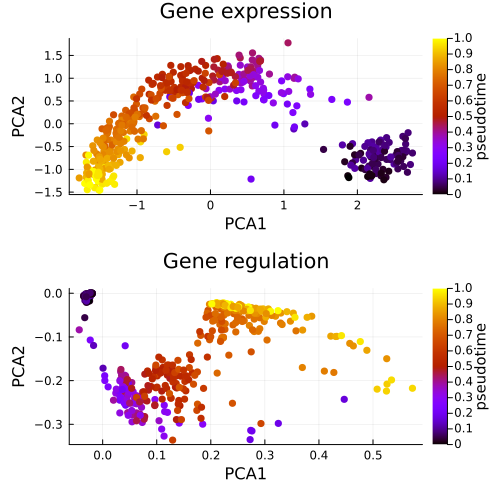

In [49]:
using MultivariateStats
M = fit(PCA, G'; maxoutdim = 3)
G_pca = (M.proj' * G')'
plt1=scatter(X_pca[:, 1], X_pca[:, 2], marker_z = dpt, color = :gnuplot, markerstrokewidth = 0, size = (PLT_CELL, PLT_CELL/2), xlabel = "PCA1", ylabel = "PCA2", colorbar_title = "pseudotime", title = "Gene expression", label = nothing)
plt2=scatter(G_pca[:, 1], G_pca[:, 2], marker_z = dpt, color = :gnuplot, markerstrokewidth = 0, size = (PLT_CELL, PLT_CELL/2), xlabel = "PCA1", ylabel = "PCA2", colorbar_title = "pseudotime", title = "Gene regulation", label = nothing)
plt=plot(plt1, plt2; size = (PLT_CELL, PLT_CELL), layout = (2, 1))
savefig(string(FIG_DIR, "mESC_pca_plots.pdf"))
plt

In [52]:
# NMF
qnorm(x, q) = x ./ quantile(vec(x), q)
Cg = cor(X).^2; Cg[diagind(Cg)] .= 0

Random.seed!(0)
U, V, trace = fitnmf(cu(relu.(qnorm(mi_all_clr, 0.9))),
                     [I(size(G, 1)), I(size(G, 2))], 1e-3*I + L,
                     cu(repeat(vec(Cg), 1, size(X, 1))'),
                     8; 
                     α = 10.0,
                     β = 0.0, 
              λ = [1, 1],
              μ = [1, 1],
              iter = 2_500, initialize = :nmf, print_iter = 50, dictionary = false, η = 1.0);
G_nmf = Array(U*V');
U = Array(U); V = Array(V);
# rescale U, V
U .*= mean(V; dims = 1)
V ./= mean(V; dims = 1);

[ Info: Initializing NMF decomposition with nmf
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


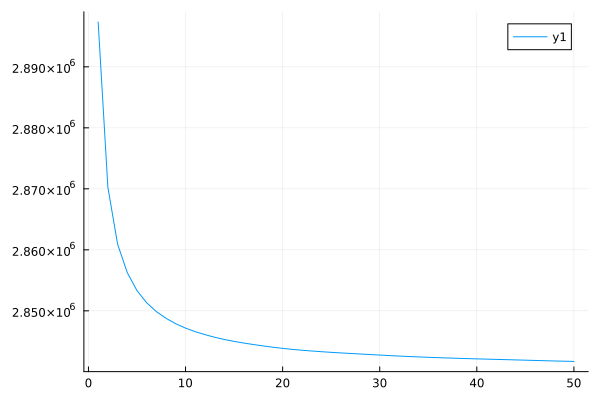

In [53]:
plot(trace)

In [59]:
npzwrite(string(DATA_PATH, "U.npy"), U)
npzwrite(string(DATA_PATH, "V.npy"), V)
npzwrite(string(DATA_PATH, "G.npy"), G)